## Dependencies

In [1]:
import os
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [2]:
hold_out_set = pd.read_csv('../input/aptos-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
X_train["id_code"] = X_train["id_code"].apply(lambda x: x + ".png")
X_val["id_code"] = X_val["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
X_train['diagnosis'] = X_train['diagnosis'].astype('str')
X_val['diagnosis'] = X_val['diagnosis'].astype('str')
display(X_train.head())

Number of train samples:  2929
Number of validation samples:  733
Number of test samples:  1928


,id_code,diagnosis,height,width,set
0,55eac26bd383.png,1,1736,2416,train
1,44e0d56e9d42.png,2,2136,3216,train
2,aa4407aab872.png,0,1050,1050,train
3,cffc50047828.png,0,614,819,train
4,b0f0fa677d5f.png,0,1050,1050,train


# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CHANNELS = 3
N_CLASSES = X_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [4]:
def kappa(y_true, y_pred, n_classes=5):
    y_trues = K.cast(K.argmax(y_true), K.floatx())
    y_preds = K.cast(K.argmax(y_pred), K.floatx())
    n_samples = K.cast(K.shape(y_true)[0], K.floatx())
    distance = K.sum(K.abs(y_trues - y_preds))
    max_distance = n_classes - 1
    
    kappa_score = 1 - ((distance**2) / (n_samples * (max_distance**2)))

    return kappa_score

def step_decay(epoch):
    lrate = 30e-5
    if epoch > 3:
        lrate = 15e-5
    if epoch > 7:
        lrate = 7.5e-5
    if epoch > 11:
        lrate = 3e-5
    if epoch > 15:
        lrate = 1e-5

    return lrate

def focal_loss(y_true, y_pred):
    gamma = 2.0
    epsilon = K.epsilon()
    
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    
    return loss

def get_1cycle_schedule(lr_max=1e-3, n_data_points=8000, epochs=200, batch_size=40, verbose=0):          
    """
    Creates a look-up table of learning rates for 1cycle schedule with cosine annealing
    See @sgugger's & @jeremyhoward's code in fastai library: https://github.com/fastai/fastai/blob/master/fastai/train.py
    Wrote this to use with my Keras and (non-fastai-)PyTorch codes.
    Note that in Keras, the LearningRateScheduler callback (https://keras.io/callbacks/#learningratescheduler) only operates once per epoch, not per batch
      So see below for Keras callback

    Keyword arguments:
    lr_max            chosen by user after lr_finder
    n_data_points     data points per epoch (e.g. size of training set)
    epochs            number of epochs
    batch_size        batch size
    Output:  
    lrs               look-up table of LR's, with length equal to total # of iterations
    Then you can use this in your PyTorch code by counting iteration number and setting
          optimizer.param_groups[0]['lr'] = lrs[iter_count]
    """
    if verbose > 0:
        print("Setting up 1Cycle LR schedule...")
    pct_start, div_factor = 0.3, 25.        # @sgugger's parameters in fastai code
    lr_start = lr_max/div_factor
    lr_end = lr_start/1e4
    n_iter = (n_data_points * epochs // batch_size) + 1    # number of iterations
    a1 = int(n_iter * pct_start)
    a2 = n_iter - a1

    # make look-up table
    lrs_first = np.linspace(lr_start, lr_max, a1)            # linear growth
    lrs_second = (lr_max-lr_end)*(1+np.cos(np.linspace(0,np.pi,a2)))/2 + lr_end  # cosine annealing
    lrs = np.concatenate((lrs_first, lrs_second))
    return lrs

class OneCycleScheduler(Callback):
    """My modification of Keras' Learning rate scheduler to do 1Cycle learning
       which increments per BATCH, not per epoch
    Keyword arguments
        **kwargs:  keyword arguments to pass to get_1cycle_schedule()
        Also, verbose: int. 0: quiet, 1: update messages.

    Sample usage (from my train.py):
        lrsched = OneCycleScheduler(lr_max=1e-4, n_data_points=X_train.shape[0],
        epochs=epochs, batch_size=batch_size, verbose=1)
    """
    def __init__(self, **kwargs):
        super(OneCycleScheduler, self).__init__()
        self.verbose = kwargs.get('verbose', 0)
        self.lrs = get_1cycle_schedule(**kwargs)
        self.iteration = 0

    def on_batch_begin(self, batch, logs=None):
        lr = self.lrs[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)         # here's where the assignment takes place
        if self.verbose > 0:
            print('\nIteration %06d: OneCycleScheduler setting learning '
                  'rate to %s.' % (self.iteration, lr))
        self.iteration += 1

    def on_epoch_end(self, epoch, logs=None):  # this is unchanged from Keras LearningRateScheduler
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        self.iteration = 0

# Pre-procecess images

In [5]:
train_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_dest_path)
os.makedirs(validation_dest_path)
os.makedirs(test_dest_path)

def crop_image(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def circle_crop(img):   
    img = crop_image(img)    
    
    height, width, depth = img.shape
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)
    
    return img 
    
def preprocess_image(base_path, save_path, image_id, HEIGHT, WIDTH, sigmaX=30):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = circle_crop(image)
    image = cv2.resize(image, (HEIGHT, WIDTH))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
    cv2.imwrite(save_path + image_id, image)
    
# Pre-procecss train set
for i, image_id in enumerate(X_train['id_code']):
    preprocess_image(train_base_path, train_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss validation set
for i, image_id in enumerate(X_val['id_code']):
    preprocess_image(train_base_path, validation_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss test set
for i, image_id in enumerate(test['id_code']):
    preprocess_image(test_base_path, test_dest_path, image_id, HEIGHT, WIDTH)

# Data generator

In [6]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

validation_datagen=ImageDataGenerator(rescale=1./255, 
                                      rotation_range=360,
                                      horizontal_flip=True,
                                      vertical_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255, 
                                rotation_range=360,
                                horizontal_flip=True,
                                vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
                              dataframe=X_train,
                              directory=train_dest_path,
                              x_col="id_code",
                              y_col="diagnosis",
                              class_mode="categorical",
                              batch_size=BATCH_SIZE,
                              target_size=(HEIGHT, WIDTH),
                              seed=seed)

valid_generator=validation_datagen.flow_from_dataframe(
                                        dataframe=X_val,
                                        directory=validation_dest_path,
                                        x_col="id_code",
                                        y_col="diagnosis",
                                        class_mode="categorical",
                                        batch_size=BATCH_SIZE,
                                        target_size=(HEIGHT, WIDTH),
                                        seed=seed)

test_generator = test_datagen.flow_from_dataframe(  
                              dataframe=test,
                              directory=test_dest_path,
                              x_col="id_code",
                              batch_size=1,
                              class_mode=None,
                              shuffle=False,
                              target_size=(HEIGHT, WIDTH),
                              seed=seed)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

In [7]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [8]:
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
class_weights = class_weight.compute_class_weight('balanced', np.unique(X_train['diagnosis'].astype('int').values), X_train['diagnosis'].astype('int').values)

metric_list = ["accuracy", kappa]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     class_weight=class_weights,
                                     verbose=1).history

Epoch 1/2
366/366 [==============================] - 84s 230ms/step - loss: 1.7028 - acc: 0.6086 - kappa: 0.7164 - val_loss: 1.5374 - val_acc: 0.4821 - val_kappa: 0.2103
Epoch 2/2
366/366 [==============================] - 79s 216ms/step - loss: 0.8940 - acc: 0.6725 - kappa: 0.7973 - val_loss: 1.6912 - val_acc: 0.4814 - val_kappa: 0.1870


# Fine-tune the complete model (1st step)

In [10]:
for layer in model.layers:
    layer.trainable = True

# lrstep = LearningRateScheduler(step_decay)
# lrcycle = OneCycleScheduler(lr_max=LEARNING_RATE, n_data_points=(train_generator.n + valid_generator.n), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=int(EPOCHS*0.8),
                                          callbacks=callback_list,
                                          class_weight=class_weights,
                                          verbose=1).history

Epoch 1/32
366/366 [==============================] - 106s 288ms/step - loss: 0.7417 - acc: 0.7329 - kappa: 0.8791 - val_loss: 0.7176 - val_acc: 0.7683 - val_kappa: 0.9149
Epoch 2/32
366/366 [==============================] - 92s 250ms/step - loss: 0.6326 - acc: 0.7633 - kappa: 0.9144 - val_loss: 0.5413 - val_acc: 0.7972 - val_kappa: 0.9316
Epoch 3/32
366/366 [==============================] - 93s 253ms/step - loss: 0.5644 - acc: 0.7811 - kappa: 0.9301 - val_loss: 0.5798 - val_acc: 0.7738 - val_kappa: 0.9283
Epoch 4/32
366/366 [==============================] - 92s 252ms/step - loss: 0.5439 - acc: 0.7876 - kappa: 0.9341 - val_loss: 0.5060 - val_acc: 0.8179 - val_kappa: 0.9452
Epoch 5/32
366/366 [==============================] - 92s 250ms/step - loss: 0.4969 - acc: 0.8142 - kappa: 0.9466 - val_loss: 0.8315 - val_acc: 0.7766 - val_kappa: 0.9197
Epoch 6/32
366/366 [==============================] - 91s 250ms/step - loss: 0.5110 - acc: 0.8118 - kappa: 0.9464 - val_loss: 0.5166 - val_acc: 

# Fine-tune the complete model (2nd step)

In [12]:
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metric_list)

In [13]:
history_finetunning_2 = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=int(EPOCHS*0.2),
                                          callbacks=callback_list,
                                          class_weight=class_weights,
                                          verbose=1).history

Epoch 1/8
366/366 [==============================] - 100s 273ms/step - loss: 0.3814 - acc: 0.8518 - kappa: 0.9650 - val_loss: 0.5045 - val_acc: 0.8152 - val_kappa: 0.9382
Epoch 2/8
366/366 [==============================] - 90s 246ms/step - loss: 0.3708 - acc: 0.8535 - kappa: 0.9672 - val_loss: 0.4911 - val_acc: 0.8193 - val_kappa: 0.9519
Epoch 3/8
366/366 [==============================] - 91s 248ms/step - loss: 0.3748 - acc: 0.8579 - kappa: 0.9677 - val_loss: 0.4880 - val_acc: 0.8234 - val_kappa: 0.9503
Epoch 4/8
366/366 [==============================] - 90s 246ms/step - loss: 0.3730 - acc: 0.8576 - kappa: 0.9674 - val_loss: 0.4559 - val_acc: 0.8262 - val_kappa: 0.9448
Epoch 5/8
366/366 [==============================] - 90s 245ms/step - loss: 0.3748 - acc: 0.8630 - kappa: 0.9698 - val_loss: 0.5218 - val_acc: 0.8138 - val_kappa: 0.9496
Epoch 6/8
366/366 [==============================] - 90s 245ms/step - loss: 0.3658 - acc: 0.8589 - kappa: 0.9707 - val_loss: 0.4900 - val_acc: 0.8359

# Model loss graph 

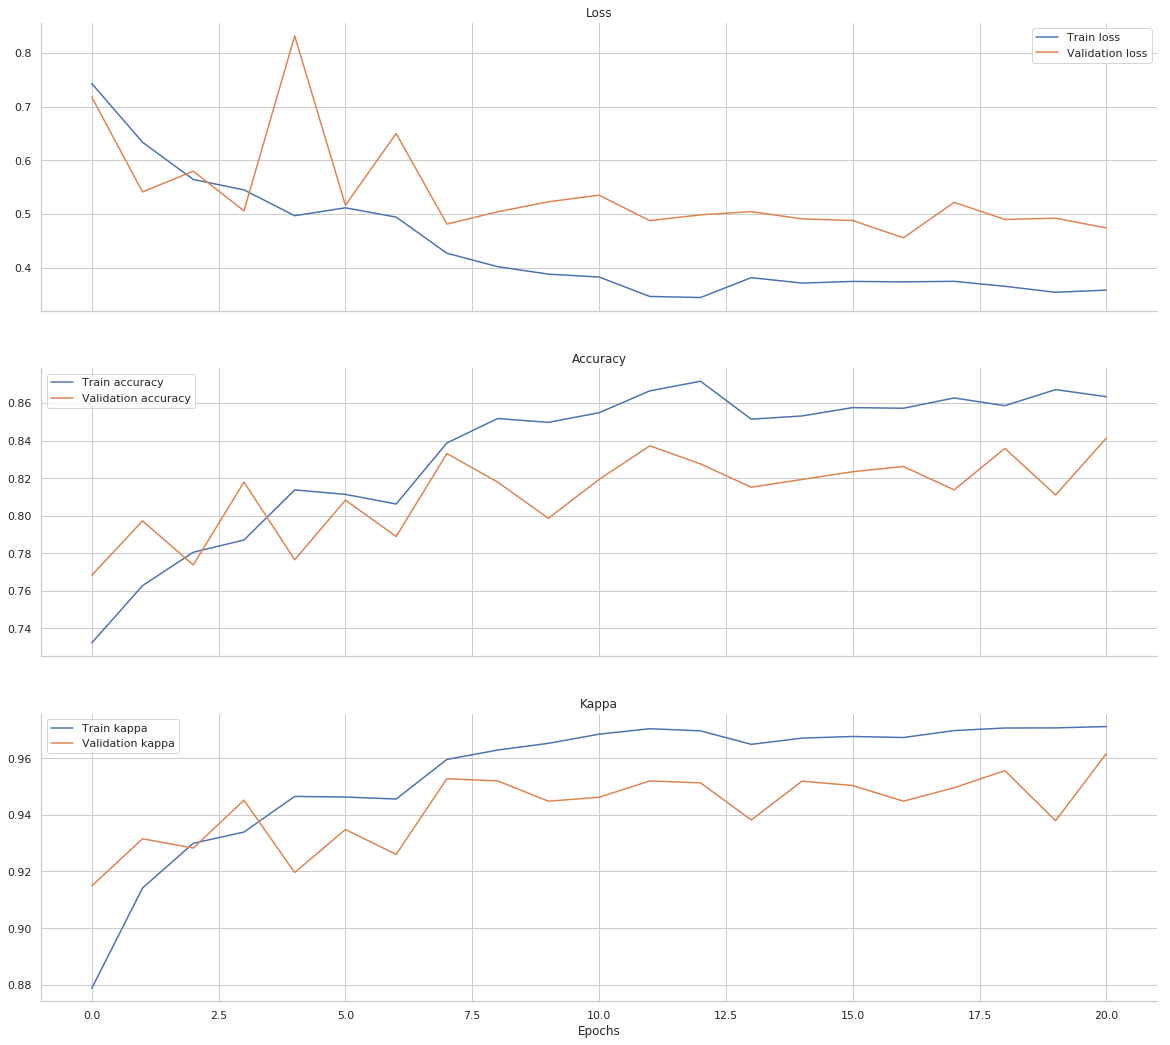

In [14]:
history = {'loss': history_finetunning['loss'] + history_finetunning_2['loss'], 
           'val_loss': history_finetunning['val_loss'] + history_finetunning_2['val_loss'], 
           'acc': history_finetunning['acc'] + history_finetunning_2['acc'], 
           'val_acc': history_finetunning['val_acc'] + history_finetunning_2['val_acc'], 
           'kappa': history_finetunning['kappa'] + history_finetunning_2['kappa'], 
           'val_kappa': history_finetunning['val_kappa'] + history_finetunning_2['val_kappa']}

sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=(20, 18))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history['kappa'], label='Train kappa')
ax3.plot(history['val_kappa'], label='Validation kappa')
ax3.legend(loc='best')
ax3.set_title('Kappa')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [15]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]
complete_labels = [np.argmax(label) for label in lastFullComLabels]

# Threshold optimization

Label 1: thr=0.500, Kappa=0.809


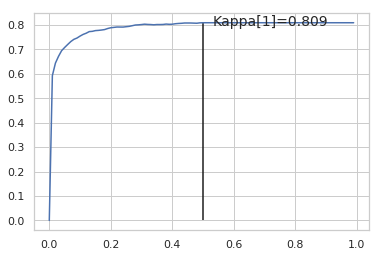

Label 2: thr=0.500, Kappa=0.809


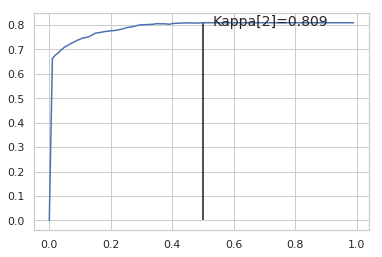

Label 3: thr=0.410, Kappa=0.809


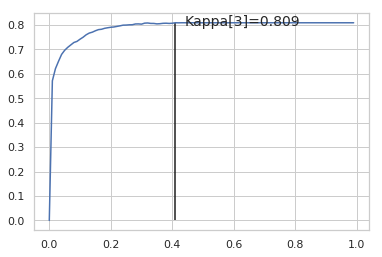

Label 4: thr=0.400, Kappa=0.810


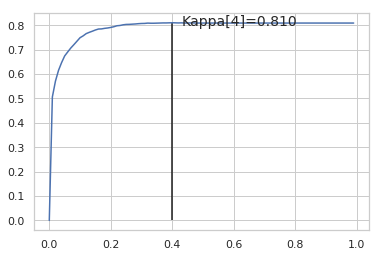

In [16]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    best_thr_list = [0 for i in range(preds.shape[1])]
    for index in range(1, preds.shape[1]):
        score = []
        thrs = np.arange(0, 1, 0.01)
        for thr in thrs:
            preds_thr = [index if x[index] > thr else np.argmax(x) for x in preds]
            score.append(cohen_kappa_score(targs, preds_thr))
        score = np.array(score)
        pm = score.argmax()
        best_thr, best_score = thrs[pm], score[pm].item()
        best_thr_list[index] = best_thr
        print('Label %s: thr=%.3f, Kappa=%.3f' % (index, best_thr, best_score))
        if do_plot:
            plt.plot(thrs, score)
            plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
            plt.text(best_thr+0.03, best_score-0.01, ('Kappa[%s]=%.3f' % (index, best_score)), fontsize=14);
            plt.show()
            
    return best_thr_list

threshold_list = find_best_fixed_threshold(lastFullComPred, complete_labels, do_plot=True)
threshold_list[0] = 0 # In last instance assign label 0

In [17]:
# Apply optimized thresholds to the train predictions
train_preds_opt = [0 for i in range(lastFullTrainPred.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(lastFullTrainPred):
        if pred[idx] > thr:
            train_preds_opt[idx2] = idx

# Apply optimized thresholds to the validation predictions
validation_preds_opt = [0 for i in range(lastFullValPred.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(lastFullValPred):
        if pred[idx] > thr:
            validation_preds_opt[idx2] = idx
            
index_order = [0, 2, 1, 4, 3]
# Apply optimized thresholds to the train predictions by class distribution
train_preds_opt2 = [0 for i in range(lastFullTrainPred.shape[0])]
for idx in index_order:
    thr = threshold_list[idx]
    for idx2, pred in enumerate(lastFullTrainPred):
        if pred[idx] > thr:
            train_preds_opt2[idx2] = idx

# Apply optimized thresholds to the validation predictions by class distribution
validation_preds_opt2 = [0 for i in range(lastFullValPred.shape[0])]
for idx in index_order:
    thr = threshold_list[idx]
    for idx2, pred in enumerate(lastFullValPred):
        if pred[idx] > thr:
            validation_preds_opt2[idx2] = idx

# Model Evaluation

## Confusion Matrix

### Original thresholds

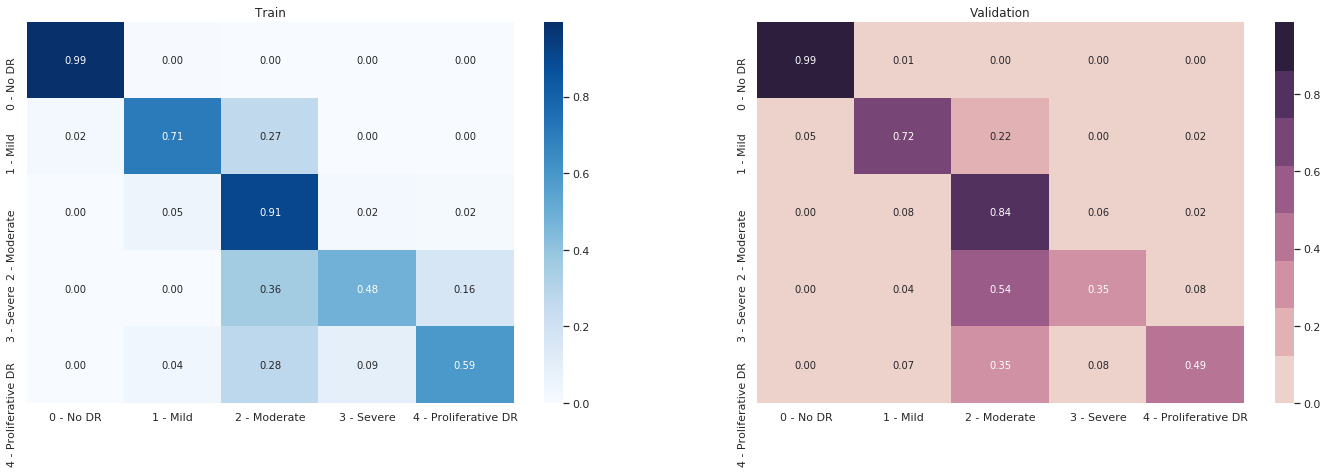

In [18]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

plot_confusion_matrix((train_labels, train_preds), (validation_labels, validation_preds))

### Optimized thresholds

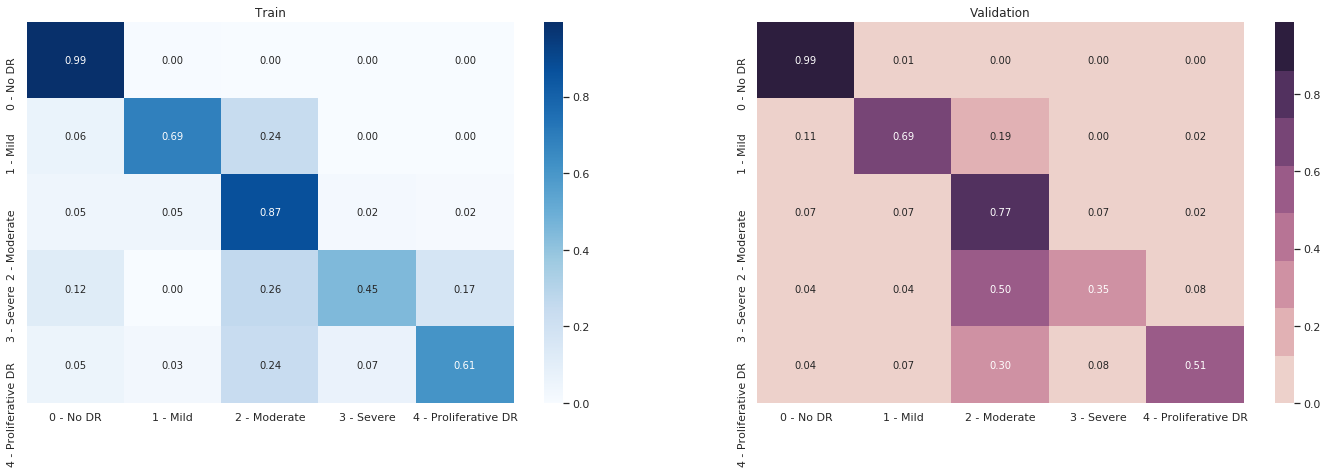

In [19]:
plot_confusion_matrix((train_labels, train_preds_opt), (validation_labels, validation_preds_opt))

### Optimized thresholds by class

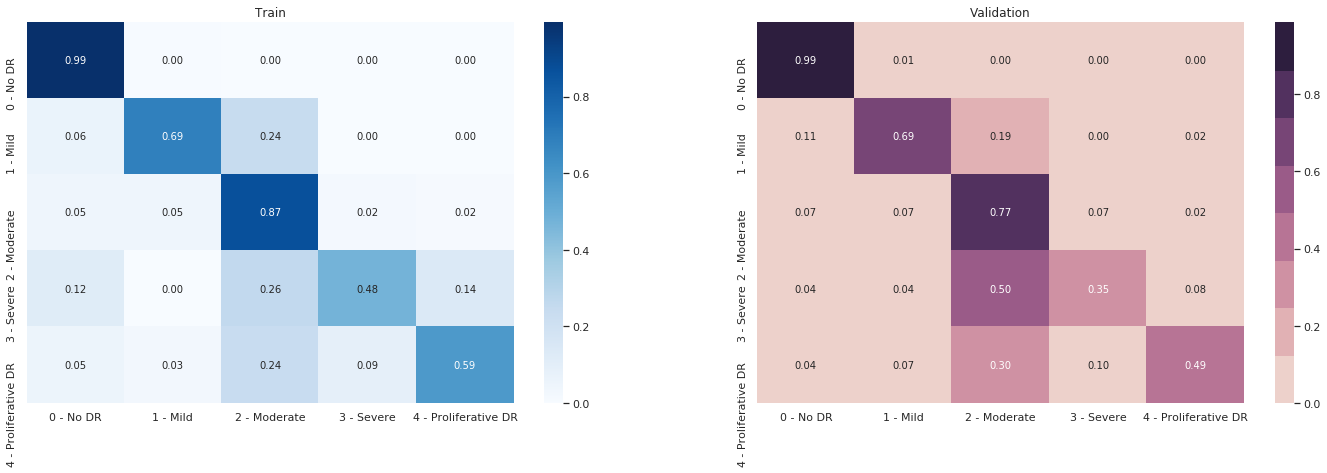

In [20]:
plot_confusion_matrix((train_labels, train_preds_opt2), (validation_labels, validation_preds_opt2))

## Quadratic Weighted Kappa

In [21]:
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))
    
print("   Original thresholds")
evaluate_model((train_preds, train_labels), (validation_preds, validation_labels))
print("   Optimized thresholds")
evaluate_model((train_preds_opt, train_labels), (validation_preds_opt, validation_labels))
print("   Optimized thresholds by class")
evaluate_model((train_preds_opt2, train_labels), (validation_preds_opt2, validation_labels))

   Original thresholds
Train        Cohen Kappa score: 0.929
Validation   Cohen Kappa score: 0.894
Complete set Cohen Kappa score: 0.922
   Optimized thresholds
Train        Cohen Kappa score: 0.883
Validation   Cohen Kappa score: 0.855
Complete set Cohen Kappa score: 0.877
   Optimized thresholds by class
Train        Cohen Kappa score: 0.882
Validation   Cohen Kappa score: 0.854
Complete set Cohen Kappa score: 0.877


## Apply model to test set and output predictions

In [22]:
def apply_tta(model, generator, steps=10):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

preds = apply_tta(model, test_generator)
predictions = np.argmax(preds, axis=1)

predictions_opt = [0 for i in range(preds.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(preds):
        if pred[idx] > thr:
            predictions_opt[idx2] = idx

predictions_opt2 = [0 for i in range(preds.shape[0])]
for idx in index_order:
    thr = threshold_list[idx]
    for idx2, pred in enumerate(preds):
        if pred[idx] > thr:
            predictions_opt2[idx2] = idx

results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

results_opt = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions_opt})
results_opt['id_code'] = results_opt['id_code'].map(lambda x: str(x)[:-4])

results_opt2 = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions_opt2})
results_opt2['id_code'] = results_opt2['id_code'].map(lambda x: str(x)[:-4])

In [23]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

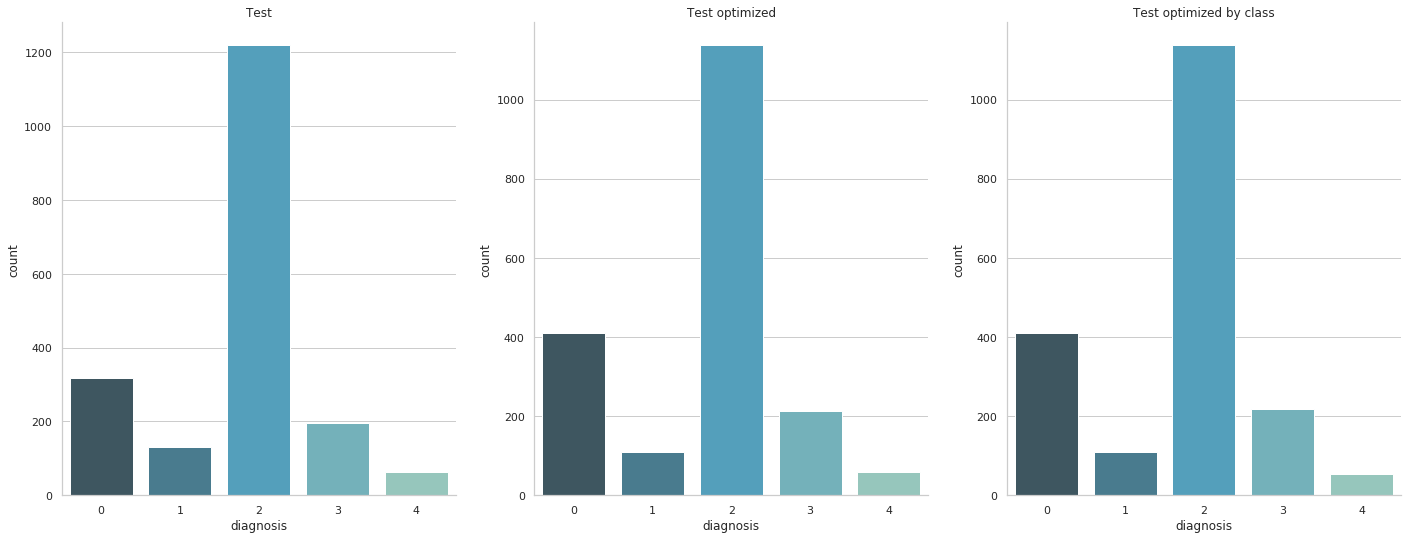

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d", ax=ax1).set_title('Test')
sns.countplot(x="diagnosis", data=results_opt, palette="GnBu_d", ax=ax2).set_title('Test optimized')
sns.countplot(x="diagnosis", data=results_opt2, palette="GnBu_d", ax=ax3).set_title('Test optimized by class')
sns.despine()
plt.show()

In [25]:
val_kappa =  cohen_kappa_score(validation_preds, validation_labels, weights='quadratic')
val_opt_kappa = cohen_kappa_score(validation_preds_opt, validation_labels, weights='quadratic')
val_opt_kappa2 = cohen_kappa_score(validation_preds_opt2, validation_labels, weights='quadratic')

if (val_kappa > val_opt_kappa) and (val_kappa > val_opt_kappa2):
    results_name = 'submission.csv'
    results_opt_name = 'submission_opt.csv'
    results_opt2_name = 'submission_opt2.csv'
elif (val_opt_kappa > val_kappa) and (val_opt_kappa > val_opt_kappa2):
    results_name = 'submission_norm.csv'
    results_opt_name = 'submission.csv'
    results_opt2_name = 'submission_opt2.csv'
else:
    results_name = 'submission_norm.csv'
    results_opt_name = 'submission_opt.csv'
    results_opt2_name = 'submission.csv'

In [26]:
results.to_csv(results_name, index=False)
display(results.head())

results_opt.to_csv(results_opt_name, index=False)
display(results_opt.head())

results_opt2.to_csv(results_opt2_name, index=False)
display(results_opt2.head())

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
